In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("winvoker/turkishsentimentanalysisdataset")

print("Path to dataset files:", path)

100%|██████████| 29.3M/29.3M [00:00<00:00, 71.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/winvoker/turkishsentimentanalysisdataset/versions/1


In [ ]:
import pandas as pd

train_df = pd.read_csv(path + "/train.csv")
test_df = pd.read_csv(path + "/test.csv")

train_df.head()

,text,label,dataset
0,ürünü hepsiburadadan alalı 3 hafta oldu. orjin...,Positive,urun_yorumlari
1,"ürünlerden çok memnunum, kesinlikle herkese ta...",Positive,urun_yorumlari
2,"hızlı kargo, temiz alışveriş.teşekkür ederim.",Positive,urun_yorumlari
3,Çünkü aranan tapınak bu bölgededir .,Notr,wiki
4,bu telefonu başlıca alma nedenlerim ise elimde...,Positive,urun_yorumlari


In [ ]:
train_df["label"].unique()

array(['Positive', 'Notr', 'Negative'], dtype=object)

In [ ]:
encoder = { "Positive": 0, "Notr": 1, "Negative": 2 }
train_df["sentiment"] = train_df["label"].map(encoder)
train_df.head()

,text,label,dataset,sentiment
0,ürünü hepsiburadadan alalı 3 hafta oldu. orjin...,Positive,urun_yorumlari,0
1,"ürünlerden çok memnunum, kesinlikle herkese ta...",Positive,urun_yorumlari,0
2,"hızlı kargo, temiz alışveriş.teşekkür ederim.",Positive,urun_yorumlari,0
3,Çünkü aranan tapınak bu bölgededir .,Notr,wiki,1
4,bu telefonu başlıca alma nedenlerim ise elimde...,Positive,urun_yorumlari,0


In [ ]:
!pip install nltk
!pip install snowballstemmer
!apt-get update -qq
!apt-get install -qq openjdk-11-jdk-headless

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA devices:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Using:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA devices: 1
Using: Tesla T4


In [ ]:
import string
import nltk
from nltk.corpus import stopwords
import snowballstemmer
stemmer = snowballstemmer.stemmer("turkish")

nltk.download("stopwords")

turkish_stopwords = set(stopwords.words("turkish"))

def clean_text(text: str) -> str:
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    words = [stemmer.stemWord(token) for token in text.split() if token not in turkish_stopwords and not token.isdigit()]
    return " ".join(words)

clean_text("Ben okula gitmek için yürüyorum.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'ben okul gitmek yürüyor'

In [ ]:
train_df["lemmatized_review"] = train_df["text"].apply(clean_text)

In [ ]:
test_df["lemmatized_review"] = test_df["text"].apply(clean_text)

In [ ]:
from collections import Counter

train_df["tokens"] = train_df["lemmatized_review"].apply(lambda s: s.split())
test_df["tokens"] = test_df["lemmatized_review"].apply(lambda s: s.split())

counter = Counter()
for toks in train_df["tokens"]:
    counter.update(toks)

class Vocab:
    def __init__(self, counter, max_size=20000, specials=None):
        specials = specials or ["<unk>", "<pad>"]
        most_common = [t for t,_ in counter.most_common(max_size)]
        self.itos = specials + most_common
        self.stoi = {t:i for i,t in enumerate(self.itos)}
        self.unk_index = self.stoi["<unk>"]

    def __len__(self):
        return len(self.itos)

    def __getitem__(self, token):
        return self.stoi.get(token, self.unk_index)

vocab = Vocab(counter, max_size=20000, specials=["<unk>","<pad>"])

In [ ]:
from torch.utils.data import Dataset, DataLoader

class SentimentDataset(Dataset):
    def __init__(self, df, vocab, label_map):
        self.vocab     = vocab
        self.tokens    = df["tokens"].tolist()
        self.labels    = [label_map[s] for s in df["label"]]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        idxs = [ self.vocab[t] for t in self.tokens[idx] ]
        return torch.tensor(idxs, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

In [ ]:
def collate_fn(batch):
    batch = [(s, l) for s, l in batch if s.size(0) > 0]
    if not batch:
        return None
    seqs, labs = zip(*batch)
    lengths = torch.tensor([len(s) for s in seqs])
    padded  = pad_sequence(seqs, batch_first=True, padding_value=vocab["<pad>"])
    return padded, lengths, torch.stack(labs)


In [ ]:
train_ds = SentimentDataset(train_df, vocab, encoder)
test_ds  = SentimentDataset(test_df,  vocab, encoder)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, collate_fn=collate_fn)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, n_layers=1, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, lengths):
        embedded = self.dropout(self.embedding(text))  # [batch, seq_len, emb_dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, _) = self.lstm(packed_embedded)

        # hidden: [num_layers, batch, hidden_dim]
        output = self.fc(self.dropout(hidden[-1]))  # son katmanın çıktısı
        return output


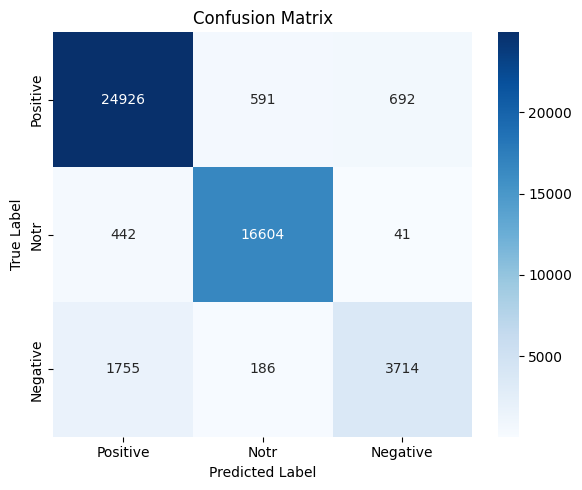


Epoch 01 | train_loss=0.2959, train_acc=0.8863 | valid_loss=0.2042, valid_acc=0.9243, prec=0.9032, rec=0.8598, f1=0.8778
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     26209
           1       0.96      0.97      0.96     17087
           2       0.84      0.66      0.74      5655

    accuracy                           0.92     48951
   macro avg       0.90      0.86      0.88     48951
weighted avg       0.92      0.92      0.92     48951



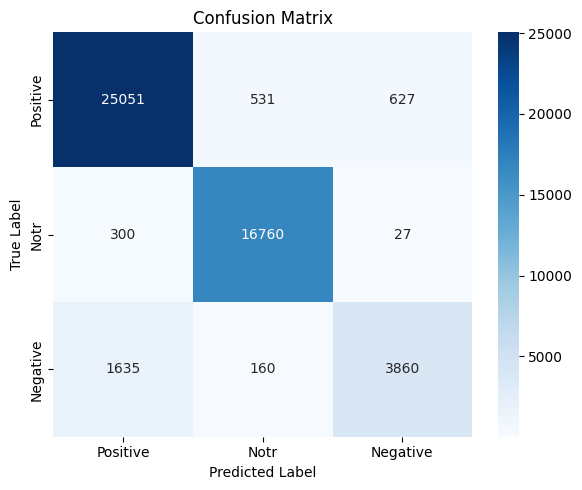


Epoch 02 | train_loss=0.2067, train_acc=0.9230 | valid_loss=0.1801, valid_acc=0.9330, prec=0.9146, rec=0.8731, f1=0.8905
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     26209
           1       0.96      0.98      0.97     17087
           2       0.86      0.68      0.76      5655

    accuracy                           0.93     48951
   macro avg       0.91      0.87      0.89     48951
weighted avg       0.93      0.93      0.93     48951



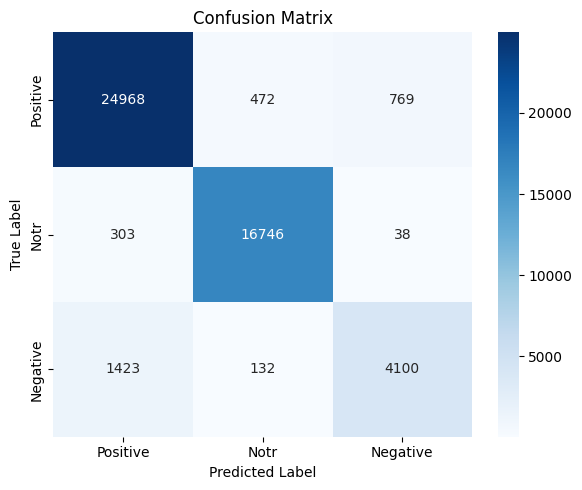


Epoch 03 | train_loss=0.1820, train_acc=0.9328 | valid_loss=0.1775, valid_acc=0.9359, prec=0.9120, rec=0.8859, f1=0.8976
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     26209
           1       0.97      0.98      0.97     17087
           2       0.84      0.73      0.78      5655

    accuracy                           0.94     48951
   macro avg       0.91      0.89      0.90     48951
weighted avg       0.93      0.94      0.93     48951



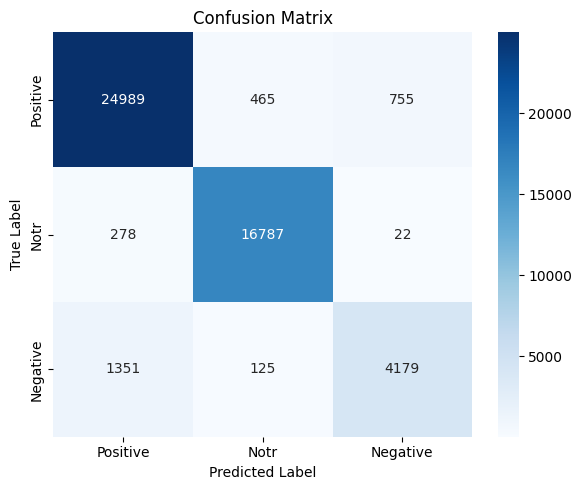


Epoch 04 | train_loss=0.1671, train_acc=0.9383 | valid_loss=0.1665, valid_acc=0.9388, prec=0.9160, rec=0.8916, f1=0.9026
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     26209
           1       0.97      0.98      0.97     17087
           2       0.84      0.74      0.79      5655

    accuracy                           0.94     48951
   macro avg       0.92      0.89      0.90     48951
weighted avg       0.94      0.94      0.94     48951



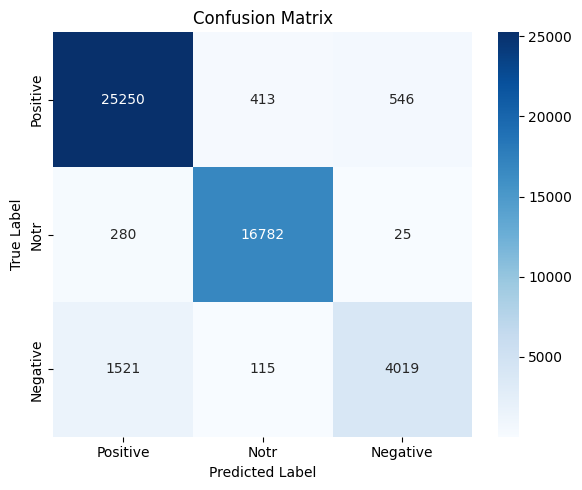


Epoch 05 | train_loss=0.1560, train_acc=0.9427 | valid_loss=0.1718, valid_acc=0.9408, prec=0.9262, rec=0.8854, f1=0.9028
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     26209
           1       0.97      0.98      0.98     17087
           2       0.88      0.71      0.78      5655

    accuracy                           0.94     48951
   macro avg       0.93      0.89      0.90     48951
weighted avg       0.94      0.94      0.94     48951



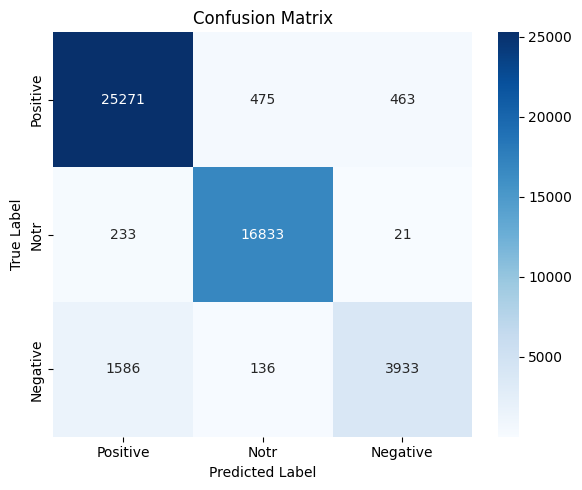


Epoch 06 | train_loss=0.1482, train_acc=0.9456 | valid_loss=0.1665, valid_acc=0.9405, prec=0.9294, rec=0.8816, f1=0.9014
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     26209
           1       0.96      0.99      0.97     17087
           2       0.89      0.70      0.78      5655

    accuracy                           0.94     48951
   macro avg       0.93      0.88      0.90     48951
weighted avg       0.94      0.94      0.94     48951



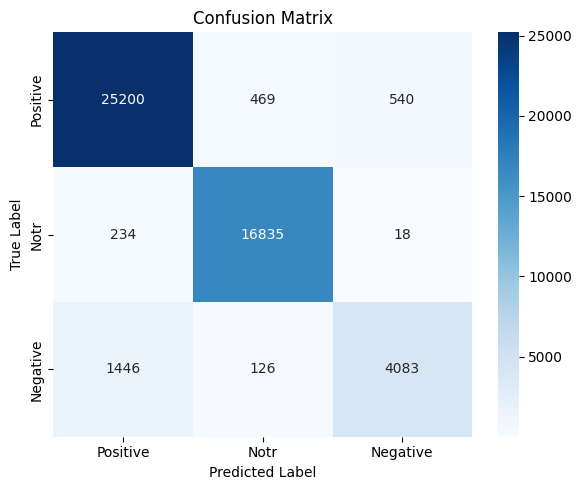


Epoch 07 | train_loss=0.1416, train_acc=0.9482 | valid_loss=0.1632, valid_acc=0.9421, prec=0.9277, rec=0.8896, f1=0.9060
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     26209
           1       0.97      0.99      0.98     17087
           2       0.88      0.72      0.79      5655

    accuracy                           0.94     48951
   macro avg       0.93      0.89      0.91     48951
weighted avg       0.94      0.94      0.94     48951



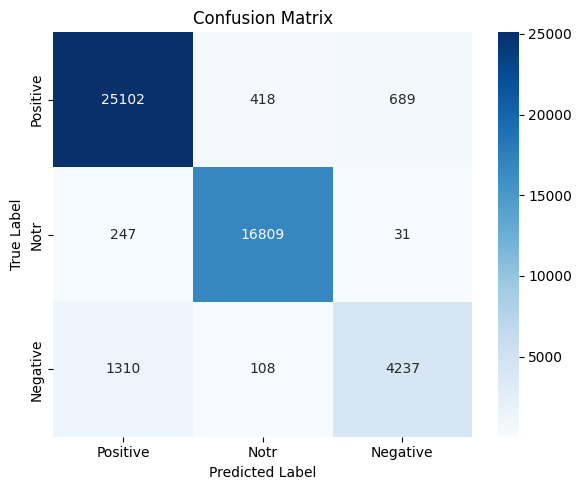


Epoch 08 | train_loss=0.1357, train_acc=0.9504 | valid_loss=0.1695, valid_acc=0.9427, prec=0.9220, rec=0.8969, f1=0.9083
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     26209
           1       0.97      0.98      0.98     17087
           2       0.85      0.75      0.80      5655

    accuracy                           0.94     48951
   macro avg       0.92      0.90      0.91     48951
weighted avg       0.94      0.94      0.94     48951



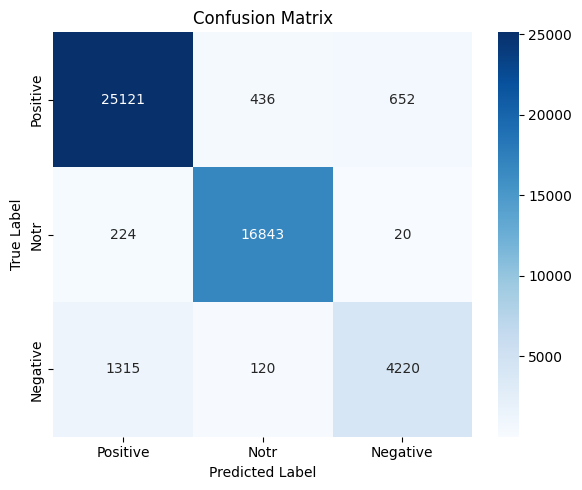


Epoch 09 | train_loss=0.1312, train_acc=0.9514 | valid_loss=0.1595, valid_acc=0.9435, prec=0.9243, rec=0.8968, f1=0.9091
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     26209
           1       0.97      0.99      0.98     17087
           2       0.86      0.75      0.80      5655

    accuracy                           0.94     48951
   macro avg       0.92      0.90      0.91     48951
weighted avg       0.94      0.94      0.94     48951



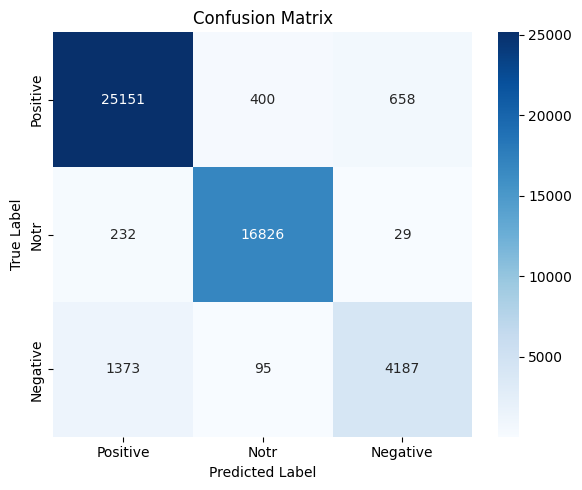


Epoch 10 | train_loss=0.1264, train_acc=0.9539 | valid_loss=0.1644, valid_acc=0.9431, prec=0.9235, rec=0.8949, f1=0.9077
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     26209
           1       0.97      0.98      0.98     17087
           2       0.86      0.74      0.80      5655

    accuracy                           0.94     48951
   macro avg       0.92      0.89      0.91     48951
weighted avg       0.94      0.94      0.94     48951



In [ ]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

VOCAB_SIZE = len(vocab)
EMB_DIM    = 100
HID_DIM    = 128
OUT_DIM    = len(encoder)
PAD_IDX    = vocab.stoi["<pad>"]

model = LSTMClassifier(VOCAB_SIZE, EMB_DIM, HID_DIM, OUT_DIM, PAD_IDX, n_layers=2, dropout=0.3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_epoch(loader):
    model.train()
    epoch_loss, all_preds, all_labels = 0, [], []
    for batch in loader:
        if batch is None: continue
        texts, lengths, labels = batch
        texts, lengths, labels = texts.to(device), lengths.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts, lengths)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss    += loss.item() * labels.size(0)
        all_preds     += outputs.argmax(1).detach().cpu().tolist()
        all_labels    += labels.detach().cpu().tolist()

    return epoch_loss/len(loader.dataset), (sum(1 for p,l in zip(all_preds,all_labels) if p==l) / len(all_labels))

def eval_epoch(loader):
    model.eval()
    epoch_loss, all_preds, all_labels = 0, [], []
    with torch.no_grad():
        for texts, lengths, labels in loader:
            texts, lengths, labels = texts.to(device), lengths.to(device), labels.to(device)
            outputs = model(texts, lengths)
            loss    = criterion(outputs, labels)

            epoch_loss  += loss.item() * labels.size(0)
            preds        = outputs.argmax(1).cpu().tolist()
            all_preds   += preds
            all_labels  += labels.cpu().tolist()

    # compute metrics
    avg_loss = epoch_loss / len(loader.dataset)
    acc      = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    classification_report_ = classification_report(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder, yticklabels=encoder)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
    return avg_loss, acc, precision, recall, f1, classification_report_

N_EPOCHS = 10
for epoch in range(1, N_EPOCHS+1):
    tr_loss, tr_acc      = train_epoch(train_loader)
    vl_loss, vl_acc, vl_prec, vl_rec, vl_f1, classification_report_ = eval_epoch(test_loader)
    print(f"\nEpoch {epoch:02} | "
          f"train_loss={tr_loss:.4f}, train_acc={tr_acc:.4f} | "
          f"valid_loss={vl_loss:.4f}, valid_acc={vl_acc:.4f}, "
          f"prec={vl_prec:.4f}, rec={vl_rec:.4f}, f1={vl_f1:.4f}")
    print(classification_report_)

In [ ]:
# Modeli kaydet
torch.save(model.state_dict(), 'lstm-model.pth')

# Modeli yükle
# model = LSTM(VOCAB_SIZE, EMB_DIM, HID_DIM, OUT_DIM, PAD_IDX, n_layers=2, dropout=0.3)
# model.load_state_dict(torch.load('sentiment_model.pth'))
# model.to(device)